# Analysis of songs and their lyrics

## Installation and loading of libraries
``` 
$ pip3 install top2vec
$ pip3 install spacy
$ [Installeren van Nederlands voor Spacy]
```

In [26]:
from top2vec import Top2Vec

import os
import spacy
import unidecode
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Data and sources


## Prints for Koppermaandag
From the 18th century onwards, so called "Koppermaandagprenten" are retained in cultural heritage institutes. These prints are a proof of the quality of printing that a printshop was able to deliver. The labourers of a printshop made a print and brought them to the customers, expecting them to buy the print, or give a tip. This extra income was used to buy drinks on "Koppermaandag", a celebration on the first Monday after Epiphany.

In 1991, an important publication is made about this type of printwork, with an overview of the retained Koppermaandagprenten. From this book the counts per year are available.

In [27]:
prentenDF = pd.read_csv("data/koppermaandagprentenCount.csv", index_col="year")

print("Number of prints: "+ str(prentenDF['count'].sum()))


Number of prints: 554


## Data about songs
Between 1848 and ca. 1914 typographical associations created booklets with lyrics of songs they sang during feasts they organized. The dataset contains a table (in CSV) with an overview of all the songs in the booklets between 1848 and 1870, with among others title, year and writer.

In [28]:
liedjesDF = pd.read_csv("data/liedjes.csv", dtype={'jaartal': 'Int32'})
liedjesDF = liedjesDF.sort_values(by=['songID'])

print("Number of songs:    " + str(len(liedjesDF)))
print("Number of booklets:  " + str(len(liedjesDF['sourceID'].unique())))

Number of songs:    759
Number of booklets:  63


## Song lyrics from files
Besides the overview of the songs in a CSV-file, for every song there is a machine readable representation of the lyrics. We use the following functions to process them.

In [49]:
def getlistOfFilenames(rootdir):
    # input: rootdir: directory with (subdirectory with) TXT-files to be handled
	# output: list of TXT-files(+path) lexicographically ordered on path-name

    files_all = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not file.endswith('.txt'):
                continue
            fn = os.path.join(subdir, file)
            files_all.append(fn)

    files_all = sorted(files_all)
    return files_all

def getlistOfTexts(listOfFilenames):
	# input: listOfFilenames: list of TXT-files(+path) lexicographically ordered on path-name
    # output: list of texts

	texts = []
	for file in listOfFilenames:
		with open(file) as stream:
			text = stream.read()
		texts.append(text)

	return texts

def lemmatize(listOfTexts, select = True, allowed_postags=["NOUN", "ADJ", "ADV", "VERB"]):   
    # input: listOfTexts: list of Dutch texts
    # input: allowed_postags: list of wordtypes to be kept in the lemmatization process
    # output: list of lemmatized Dutch texts (list of lists of words). Lemmatization by spaCy.

    nlp = spacy.load("nl_core_news_sm") # create spaCy processor named 'nlp' based on small model for Dutch

    result = []                                                         
    for text in listOfTexts:                                                     

        nlp.max_length = len(text)  
        doc = nlp(text) # tokenize and annotate 'text' with processor named 'nlp'

        new_text = []
        for token in doc: 
            if token.is_alpha: # keep tokens with alphanumerical characters (so no numbers or punctuation)
                if not token.is_stop: # remove stopwords
                    if select:
                            if token.pos_ in allowed_postags: # keep wordtypes in the allowed_postags list
                                new_text.append(unidecode.unidecode(token.lemma_)) # get the word in the lemma and add it to the list of words
                    else: new_text.append(unidecode.unidecode(token.lemma_))

        result.append(" ".join(new_text)) # add text to the list of lemmatized texts

    return result
    
def replace(listOfWords, replaceWords):
    # input: listOfWords: list 
    i = 0
    for word in listOfWords:
        if word in replaceWords:
            listOfWords[i] = replaceWords[word]
        i = i + 1

    return listOfWords

def remove(listOfWords, removeWords):
    i = 0
    for word in listOfWords:
        if word in removeWords:
            listOfWords.pop(i)
        i = i + 1

    return listOfWords

def preprocess(listOfTexts, replaceDict, removeList):
    result = []
    for liedje in listOfTexts:
        liedje = liedje.lower().split()
        preprocessedLiedje = remove(replace(liedje, replaceDict), removeList)
        result.append(" ".join(preprocessedLiedje))

    return result

We use the above functions to read the lyrics.

In [50]:
liedjesFilenames    = getlistOfFilenames('data/lyrics')
liedjes             = getlistOfTexts(liedjesFilenames)
lemmatizedLiedjes   = lemmatize(liedjes, select = False)

replaceDict = {"koster":"coster", "costers":"coster", "kosters":"coster", "vreugd":"vreugde", "blijd":"blijde"}
removeList  = ["ha", "deez", "zoo", "hoezee", "tra", "la", "li", "eene", "gaan", "komen", "laten", "weer", "vinden", "uw", "staan", "waarmee", "immer", "t", "d", "wijze", "hurah"]

preprocessedLiedjes = preprocess(lemmatizedLiedjes, replaceDict, removeList)

To investigate whether our code has worked, we look at the data of song with number ```n```.

In [51]:
n = 446

print("-- data: --")
print(liedjesDF.iloc[n])
print("-- path: --")
print(liedjesFilenames[n])
print("-- song: --")
print(liedjes[n])
print("-- lemmatized song: --")
print(lemmatizedLiedjes[n])
print("-- preprocessed song: --")
print(preprocessedLiedjes[n])


-- data: --
typoID                                     middelburg1847
sourceID                   middelburg1847-feestbundel1864
songID                  middelburg1847-feestbundel1864-22
titel                                       Landtogt 1853
wijze                                          Morgenlied
jaartal                                              1853
schrijver                                             NaN
vereniging_schrijver                       middelburg1847
wordcount                                              96
topic                                                   0
topic_score                                      0.732562
Name: 416, dtype: object
-- path: --
data/lyrics/middelburg1847/middelburg1847-feestbundel1864/middelburg1847-feestbundel1864-22.txt
-- song: --
LANDTOGT 1853 - Morgenlied.

Voorbij is dan het nachtlijk uur,
En voor het stil en sombre duister,
Herrijst (wat wonder, der natuur!)
Alweêr de dag met nieuwen luister;
Aurora kleurt des Hemels boog,
Het f

# Count 
The development of the number of particular retained heritage of printing in the nineteenth century might say something about the change of relevance for printers to create these prints. In this notebook the development of printing heritage is investigated.



## Number of Koppermaandagprenten per year
First, we study the number of Koppermaandagprenten per year. We smooth the count with a five year rolling mean. We observe two timeperiods where the making of these prints was popular: the 1820's and between 1840-1860.

<AxesSubplot: xlabel='year'>

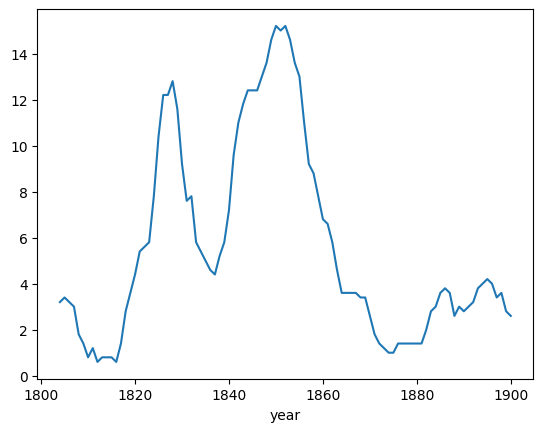

In [32]:
prentenDF['count'].rolling(5).mean().plot()

## Number of songs and number of words per year
Secondly, we want to investigate how much songs are in the dataset per year. We smooth the outcome again with a five years rolling mean. We observe a popularity for creating songs between 1850 en 1865.

<AxesSubplot: xlabel='jaartal'>

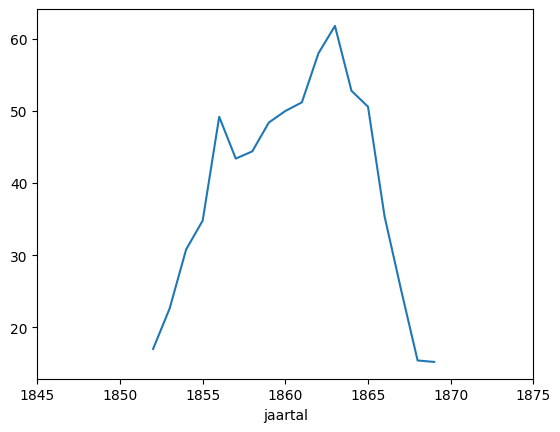

In [52]:
liedjesDF.groupby('jaartal').size().rolling(5).mean().plot(xlim=(1845,1875))

We study the number of words per year, instead of the number of songs per year for a potentially more precise indication. We calculate the number of words per song and add this to the liedjes DataFrame.

(array([ 0.,  0.,  2.,  3.,  3.,  5.,  9., 17., 21., 41., 31., 63., 73.,
        79., 54., 43., 41., 43., 43., 28., 35., 16., 19., 23., 14., 13.,
         5., 11.,  4.,  4.,  2.,  2.,  0.,  3.,  3.,  0.,  1.,  0.,  0.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
        110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
        165., 170., 175., 180., 185., 190., 195.]),
 <BarContainer object of 39 artists>)

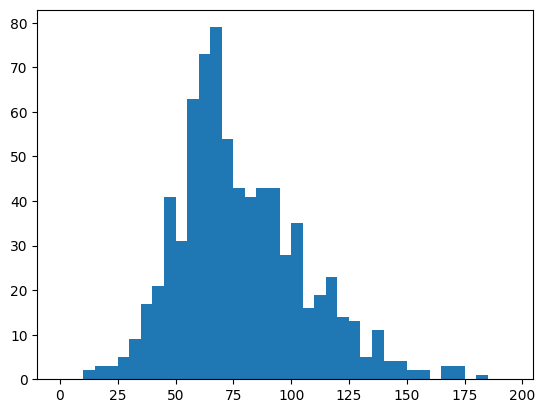

In [53]:
numberOfSongs = len(liedjes)

listOfWordlists = [] 
for i in range(0,numberOfSongs): listOfWordlists.append(preprocessedLiedjes[i].split())

listOfWordcounts = []
for i in range(0,numberOfSongs): listOfWordcounts.append(len(listOfWordlists[i]))

plt.hist(listOfWordcounts, bins=range(0,200,5), range=[0,200])


In [54]:
liedjesDF['wordcount'] = listOfWordcounts
liedjesDF.iloc[n]


typoID                                     middelburg1847
sourceID                   middelburg1847-feestbundel1864
songID                  middelburg1847-feestbundel1864-22
titel                                       Landtogt 1853
wijze                                          Morgenlied
jaartal                                              1853
schrijver                                             NaN
vereniging_schrijver                       middelburg1847
wordcount                                              94
topic                                                   0
topic_score                                      0.732562
Name: 416, dtype: object

<AxesSubplot: xlabel='jaartal'>

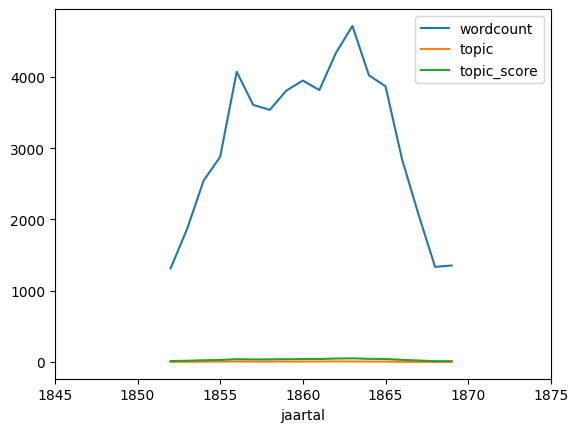

In [55]:
liedjesDF.groupby('jaartal').sum('wordcount').rolling(5).mean().plot(xlim=(1845,1875))

## Average size of a song per year
So the number of songs and the total number of words in the lyrics per year does not differ that much. How about the average size of a song per year? 

<AxesSubplot: xlabel='jaartal'>

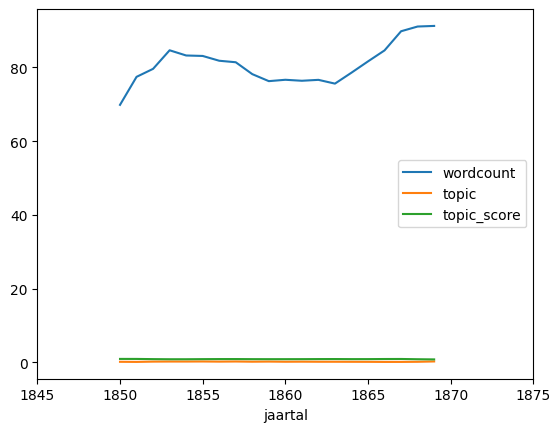

In [56]:
liedjesDF.groupby('jaartal').mean('wordcount').rolling(3).mean().plot(xlim=(1845,1875))

## Number of booklets per year
The number of booklets per year. Some booklets contain larger collections of songs through time of one typographical association (Middelburg) or of various associations on one moment (on the occasion of the erection of the statue of Coster in Haarlem 1856). We create a slice of the DataFrame without these books (with more than 50 songs) to have a better overview of the books created by associations in their own reasons. For the same reason we remove from this slice the singular songs that are retained over time (so we select booklets we at least 3 songs).

<AxesSubplot: xlabel='year'>

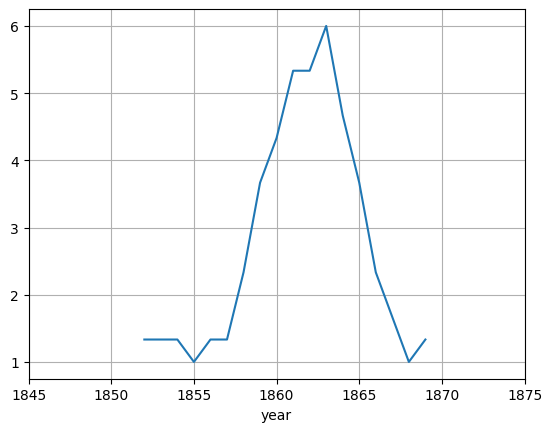

In [57]:
boekjesDF    = pd.read_csv('data/boekjes.csv')
boekjesSlice = boekjesDF.loc[boekjesDF['size'] < 50].loc[boekjesDF['size'] > 2]
boekjesSlice.groupby('year').size().rolling(3).mean().plot(xlim=(1845,1875), grid=True)

## Compare the number of Koppermaandagprenten with the number of songs

<AxesSubplot: xlabel='year'>

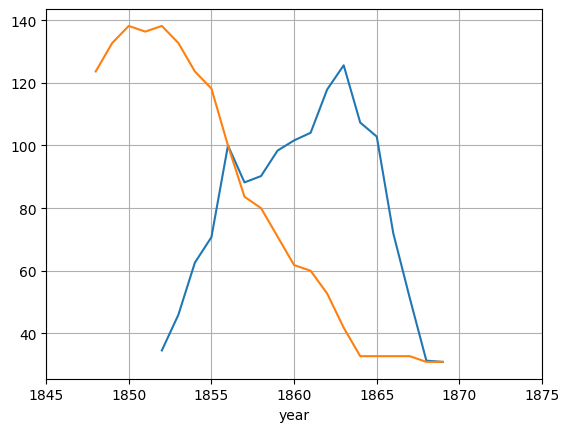

In [58]:
liedjesSerie = liedjesDF.groupby('jaartal').size().rolling(5).mean()
prentenSerie = prentenDF['count'].rolling(5).mean()

baseYear = 1856

indexCijfersLiedjes = []
for year in range(1848,1870): indexCijfersLiedjes.append((liedjesSerie.loc[year] / liedjesSerie.loc[baseYear]) * 100)

indexCijfersPrenten = []
for year in range(1848,1870): indexCijfersPrenten.append((prentenSerie.loc[year] / prentenSerie.loc[baseYear]) * 100)

indexCijfersDF = pd.DataFrame()
indexCijfersDF['year'] = range(1848,1870)
indexCijfersDF['liedjesIndex'] = indexCijfersLiedjes
indexCijfersDF['prentenIndex'] = indexCijfersPrenten

indexCijfersDF = indexCijfersDF.set_index('year')
indexCijfersDF['liedjesIndex'].plot(xlim=(1845,1875), grid=True)
indexCijfersDF['prentenIndex'].plot(xlim=(1845,1875), grid=True)




## Average size of booklets per year, in number of songs and number of words

# Topics with Top2Vec
Do the topics of songs change over time?

In [59]:
model = Top2Vec(preprocessedLiedjes)

2023-01-14 12:45:34,447 - top2vec - INFO - Pre-processing documents for training
2023-01-14 12:45:34,696 - top2vec - INFO - Creating joint document/word embedding
2023-01-14 12:45:37,357 - top2vec - INFO - Creating lower dimension embedding of documents
2023-01-14 12:45:51,463 - top2vec - INFO - Finding dense areas of documents
2023-01-14 12:45:51,493 - top2vec - INFO - Finding topics


In [41]:
model.topic_sizes

0    649
1    110
dtype: int64

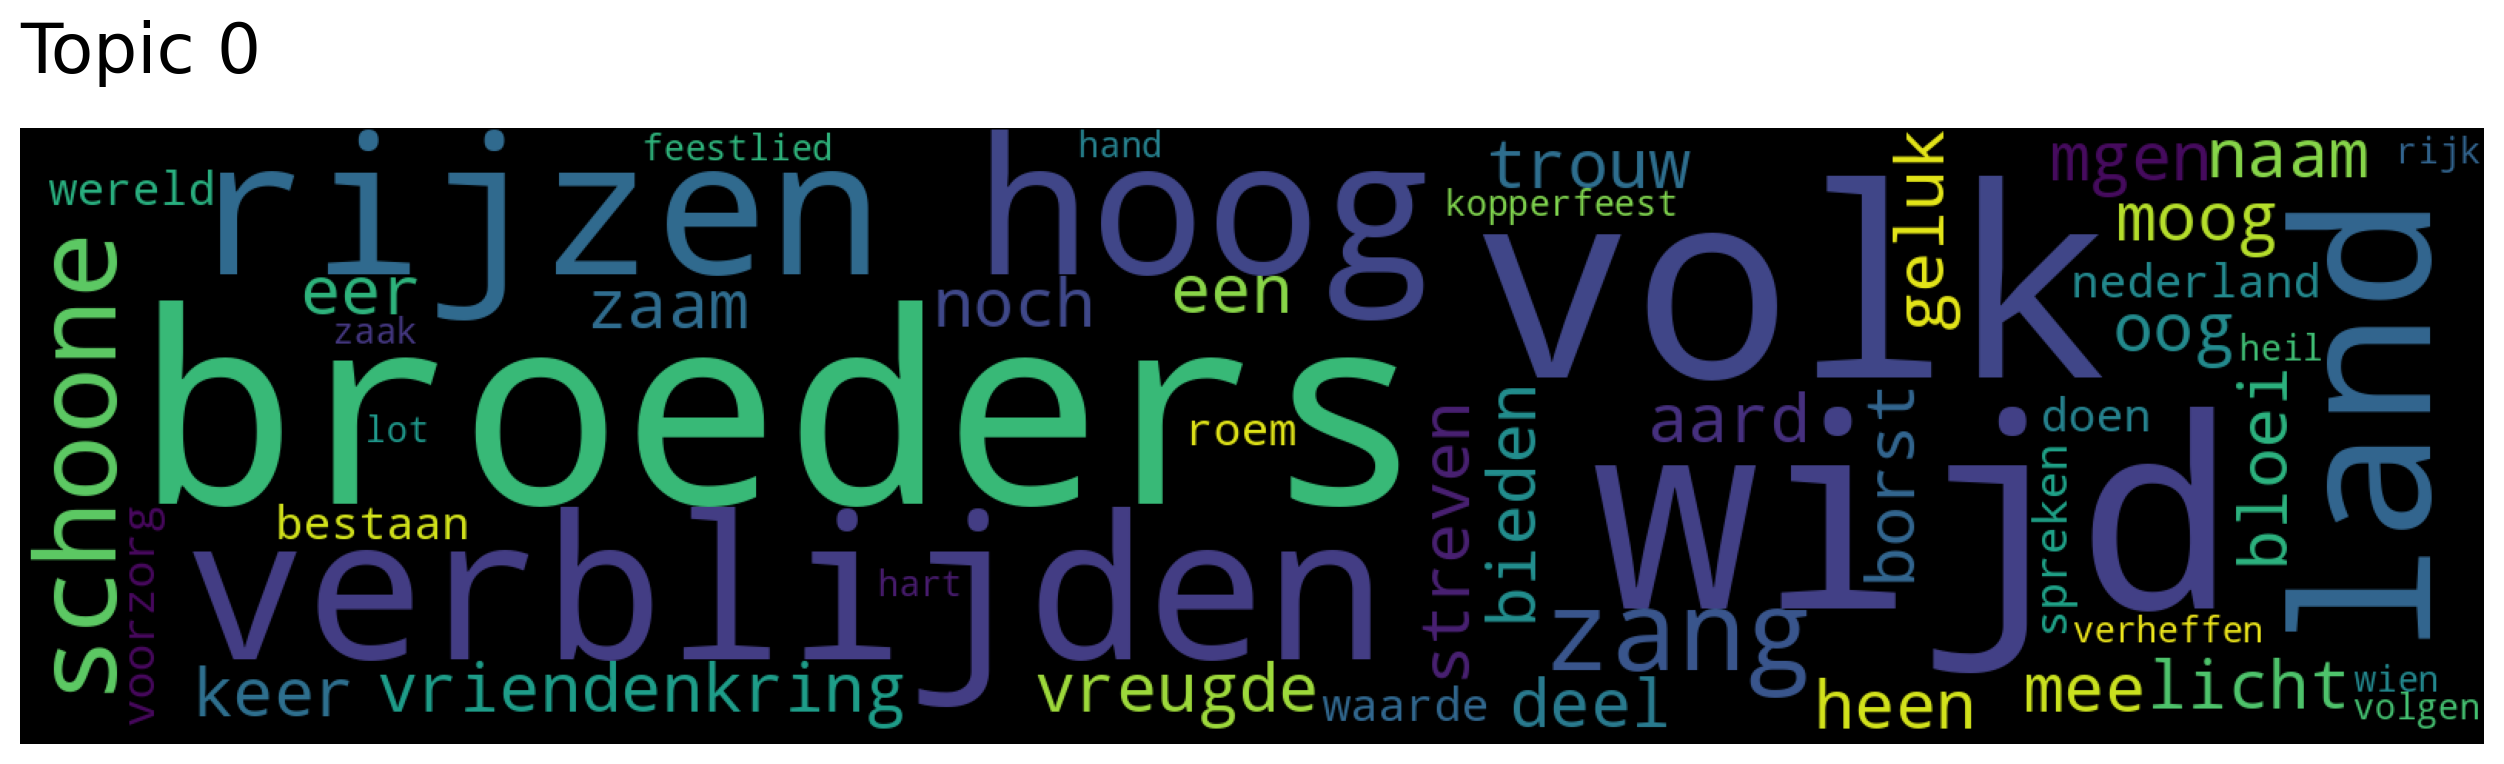

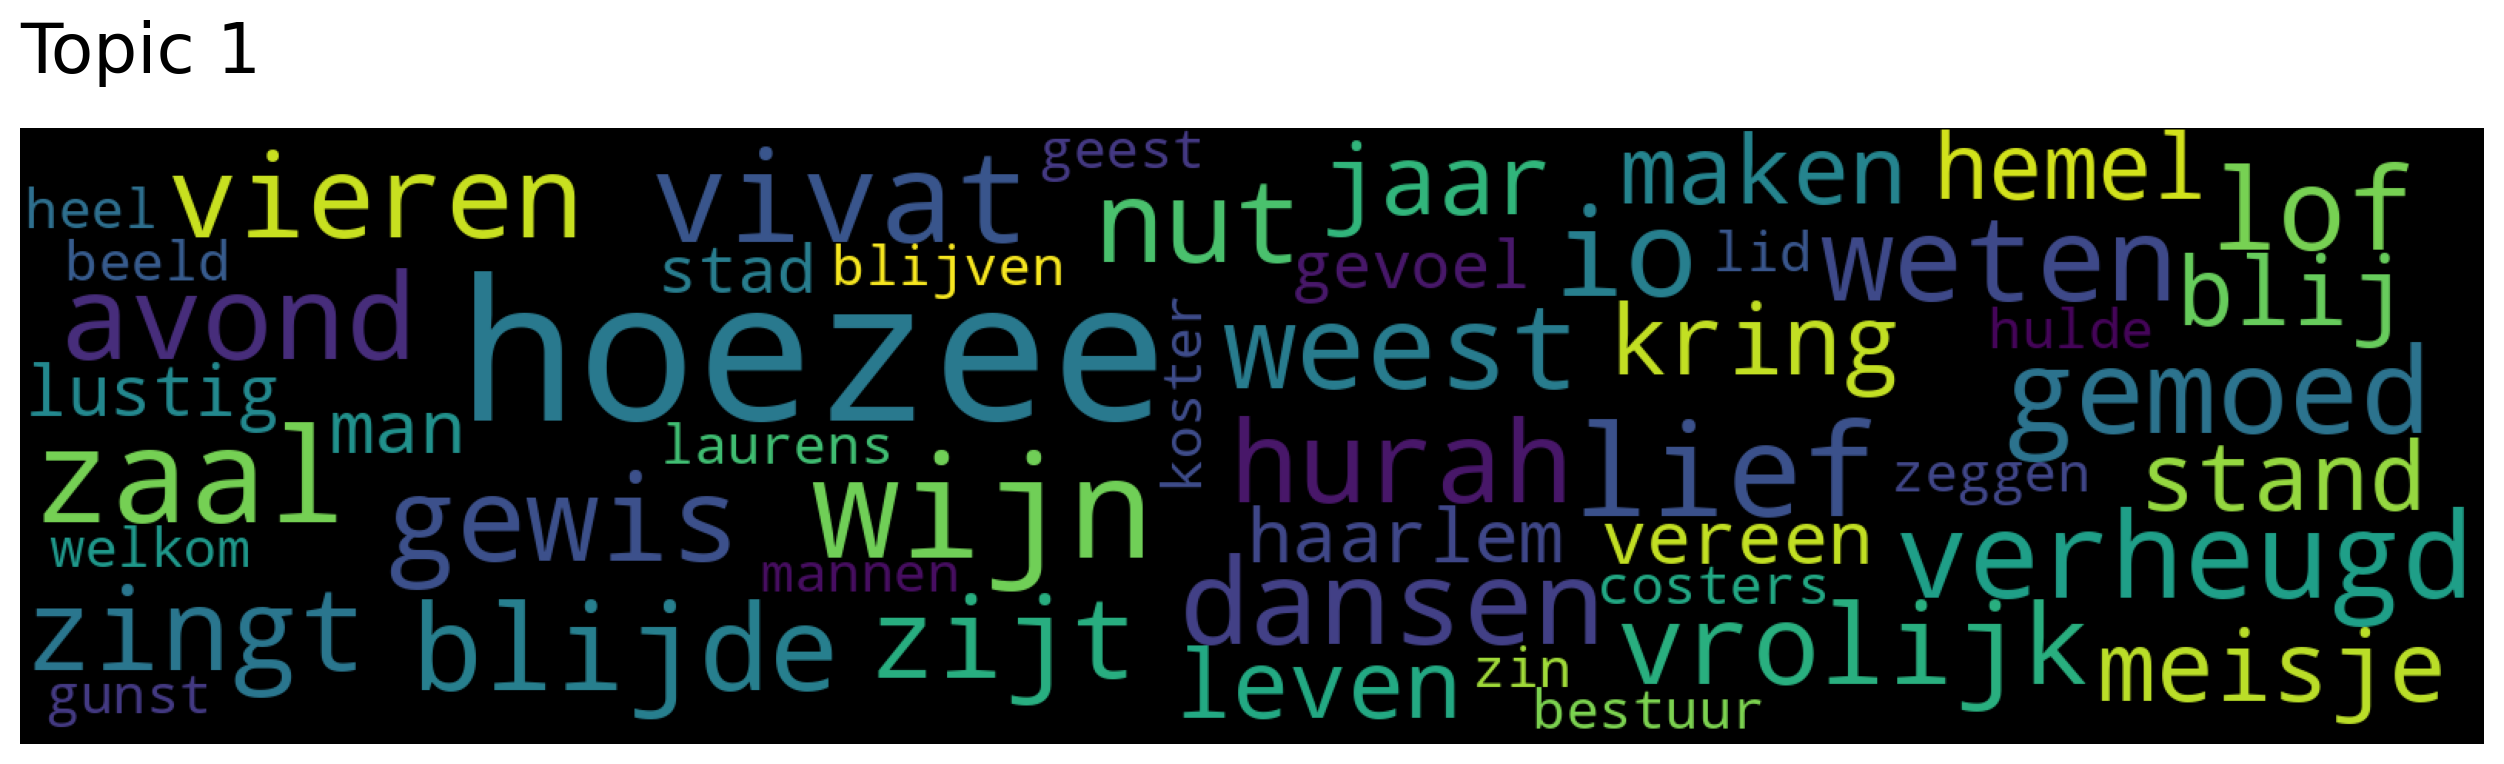

In [42]:
topic_sizes, topic_nums = model.get_topic_sizes()
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [60]:
model.get_documents_topics([8])

(array([1]),
 array([0.93447775], dtype=float32),
 array([['lid', 'hoezee', 'bestuur', 'smaken', 'dansen', 'triomf',
         'voorwaarts', 'genieten', 'drinken', 'wijn', 'glas', 'vrolijk',
         'blijde', 'luid', 'verheugd', 'nieuw', 'klinken', 'zijt',
         'vieren', 'kopperfeest', 'vreugde', 'feest', 'maken', 'waard',
         'vriendschap', 'komt', 'hallo', 'io', 'tijd', 'kring',
         'vriendenkring', 'lief', 'denken', 'welkom', 'zorg', 'zaak',
         'onderling', 'weest', 'vol', 'klink', 'kracht', 'voorzorg',
         'wijden', 'hemel', 'hulp', 'schonk', 'goed', 'lof', 'jaar',
         'vivat']], dtype='<U13'),
 array([[-0.6178914 , -0.6780405 , -0.68764496, -0.74438655, -0.74827826,
         -0.75549805, -0.76747185, -0.7837798 , -0.7887243 , -0.8006759 ,
         -0.8137098 , -0.8341276 , -0.8367799 , -0.86969155, -0.8782521 ,
         -0.8797561 , -0.8825566 , -0.8918156 , -0.8925    , -0.8947532 ,
         -0.89497846, -0.89605457, -0.90023273, -0.90042466, -0.9080

In [61]:
doc_ids = list(range(0, len(liedjesDF)))
topics, topic_scores, topic_words, words_score = model.get_documents_topics(doc_ids)

liedjesDF['topic'] = topics
liedjesDF['topic_score'] = topic_scores

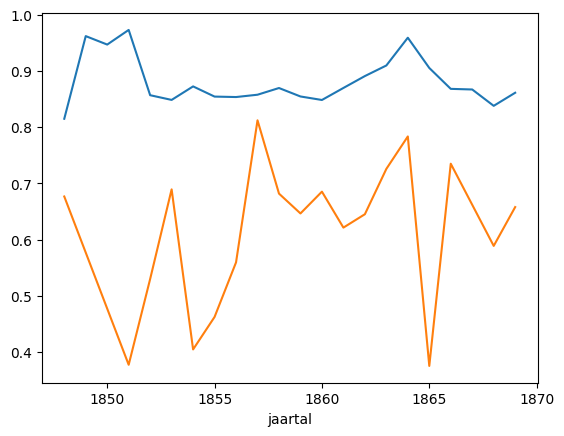

In [62]:
for topic in topic_nums:
    df = liedjesDF.loc[liedjesDF.topic == topic]
    dfAvg = df.groupby('jaartal').mean('topic_score')
    dfAvg['topic_score'].plot()


# Handmade topics
* nationalism: ["willem", "vaderland", "coster"]
* relation with patrons: ["donateur", "ereleden"]
* grievances ["loon", "zegel"]

In [71]:
def extract_vocabulary(tokenized_corpus, min_count=1, max_count=float('inf')):
	# Result: list of unique words derived from a list of lists of strings
	vocabulary = collections.Counter()
	for document in tokenized_corpus:
		vocabulary.update(document)
	vocabulary = { 
		word for word, count in vocabulary.items()
		if count >= min_count and count <= max_count
	}

	return sorted(vocabulary)

def corpus2dtm(tokenized_corpus, vocabulary):
	# Result: Document Term Matrix: 
	# rows being documents in tokenized_corpus, columns being the words in vocabulary, 
	# values being the count of the word in the document
	document_term_matrix = []
	for document in tokenized_corpus:
		document_counts = collections.Counter(document)
		row = [document_counts[word] for word in vocabulary]
		document_term_matrix.append(row)

	return document_term_matrix

def listify(listOfTexts):
    result = []
    for liedje in listOfTexts:
        liedje = liedje.split()
        result.append(liedje)

    return result

def topics2vectors(topicList, vocabulary):
    result = []
    for topic in topicList:
        topicVector = []
        for term in vocabulary:
            if term in topic:
                topicVector.append(1)
            else:
                topicVector.append(0)
        result.append(topicVector)

    return result


In [68]:
listifiedLiedjes = listify(preprocessedLiedjes)
liedjesVocabulary = extract_vocabulary(listifiedLiedjes, min_count=10)
dtmLiedjes = np.array(corpus2dtm(listifiedLiedjes, liedjesVocabulary))

len(liedjesVocabulary)

1044

In [70]:
# print most important words of song $n
for i in range(len(dtmLiedjes[n])):
    if dtmLiedjes[n][i] > 0:
        print(liedjesVocabulary[i])

begeven
blijdschap
bloem
boeien
broeder
coster
dag
dankbre
duister
eeer
elkaar
getrouw
groen
haak
harmonie
heel
heerlijk
hemel
hooren
iedereen
jaar
kant
landtogt
leus
lied
luister
naam
natuur
neer
nieuwen
o
oog
past
pracht
schoon
schoonst
spreiden
stil
streven
toon
uur
verblijd
verlangen
vrucht
wensch
werken
wien
zaam
ziet
zingen


todo:
- cos-distance uitrekenen van de topicVector met de liedjes
- gemiddelde cos-distance per jaar uitrekenen en in een grafiek zetten


In [72]:
topicList = [['jenever',  'alcohol',  'drank',  'spraakwater',  'aperitief',  'biertje',  'bier',  'brouwsel',  'gerstenat',  'donker_bier',  'stout',  'stout',  'vatbier',  'pils',  'pilsener',  'bokbier',  'pils',  'pilsener',  'mede',  'appelwijn',  'cider',  'eigenstook',  'koemis',  'likeur',  'absint',  'amaretto',  'benedictijner',  'chartreuse',  'Drambuie',  'drank',  'arak',  'aqua_vitae',  'brandewijn',  'brandy',  'appeldrank',  'appelbrandewijn',  'Calvados',  'cognac',  'grappa',  'vuur_water',  'wie_verre_reizen_doet,_kan_veel_verhalen',  'gin',  'ouzo',  'rum',  'grog',  'toddy',  'Schnaps',  'tequila',  'vodka',  'wodka',  'whisky',  'Drambuie',  'cocktail',  'bloody_mary',  'Martini',  'martini',  'gin-tonic',  'grog',  'toddy',  'punch',  'Advocaat',  'advokaat',  'bocht',  '-halve',  'druivenat',  'druivennat',  'wijn',  'roos',  'Bourgondië',  'dessertwijn',  'Marsala',  'porto',  'sherry',  'xeres',  'xereswijn',  'gekruide_wijn',  'bocht',  'rode_wijn',  'schuimwijn',  'champagne',  'rassen',  'vermout',  'wijnjaar',  'wijnoogst',  'witte_wijn',  'Moezel',  'Moselle',  'rijnwijn',  'riesling',  'zak',  'Sauterne',  'drinkglas',  'glaasje',  'glas',  'bierglas',  'likeurglaasje',  'roemer',  'romer',  'wijnbeker',  'wijnroemer',  'borrelglas',  'jeneverglas',  'borrel',  'bel',  'fluit',  'beker',  'bak',  'kop',  'tas',  'beker',  'kelk',  'miskelk',  'koffiekop',  'koffiekopje',  'mokkakopje',  'espressokopje',  'kylix',  'theekopje',  'drinken',  'oplebberen',  'oplikken',  'opslobberen',  'opslorpen',  'opslurpen',  'aanzuigen',  'opzuigen',  'zuigen',  'aanstoten',  'klinken',  'proosten',  'toasten',  'toosten'], ['vriendenkring',  'samenleving',  'gilde',  'gezelschap',  'sociëteit',  'orde',  'club',  'vereniging',  'boekenclub',  'vrouwenclub',  'zusterschap',  'zeilvereniging',  'partner',  'lid',  'compagnon',  'medewerker',  'bepaling',  'aannemen',  'lid_maken_van',  'affiliëren',  'bondgenoot',  'bondgenote',  'vrind',  'compagnon',  'zakenvriend',  'vriend',  'vennoot',  'deelgenoot',  'compagnon',  'partner',  'mede-werker',  'gildebroeder',  'gildenbroeder',  'medewerker',  'vakbroeder',  'vakgenoot',  'collega',  'ambtgenoot',  'ambtsbroeder',  'ambtsgenoot',  'confrater',  'confrère',  'gildebroeder',  'gildenbroeder',  'medebroeder',  'vakbroeder',  'vakgenoot',  'lid',  'directielid',  'broer',  'broeder',  'vrijmetselaar',  'gevolmachtigde',  'commissaris',  'bestuurslid',  'commissielid',  'gemeenteraadslid',  'raadslid',  'stamgenoot',  'deelhebber',  'deelnemer',  'participant',  'genodigde',  'aanwezige',  'feestganger',  'feestvierder',  'bruidegom',  'deelgenoot',  'Pooler',  'makker',  'medespeler',  'ploegmaat',  'ploegmakker',  'teamgenoot',  'broederlijkheid',  'broederschap',  'gemeenschap',  'saamhorigheid',  'verbondenheid',  'kameraadschap',  'vriendschap',  'vriendschappelijkheid',  'vriendschapsband',  'vriendschapsbanden',  'kameraadschap'], ['drukkunst',  'boekdrukkunst',  'drukken',  'lithograferen',  'steendrukken',  'stencilen',  'drukker',  'typograaf',  'letterzetter',  'machinezetter',  'typograaf',  'zetter',  'binder',  'boekbinder',  'drukpers',  'pers',  'boekdrukkerij',  'drukkerij',  'drukpers'], ['beeld',  'beeldhouwwerk',  'sculptuur',  'borstbeeld',  'buste',  'camee',  'schriftteken',  'glief',  'mobiel',  'mobile',  'afgietsel',  'gietsel',  'replica',  'reliëf',  'standbeeld',  'beeld',  'Sfinx',  'sfinx',  'metaal',  'alkalimetaal',  'aluminium',  'americium',  'antimonium',  'antimoon',  'barium',  'bariumoxyde',  'berkelium',  'beryllium',  'astin',  'bismut',  'cadmium',  'calcium',  'californium',  'cerium',  'caesium',  'cesium',  'chromium',  'chroom',  'chromium',  'chroom',  'kobalt',  'koperbruin',  'koper',  'cirium',  'curium',  'dysprosium',  'einsteinium',  'erbium',  'europium',  'fermium',  'francium',  'gadolinium',  'gallium',  'hafnium',  'metal',  'zware_metalen',  'holmium',  'indium',  'iridium',  'strijkijzer',  'ijzer',  'goteling',  'gietijzer',  'smeedijzer',  'kunstsmeedwerk',  'lanthanium',  'lanthaan',  'ik_zoek_een_baan',  'lood',  'lithium',  'lutetium',  'magnesium',  'mangaan',  'kwik',  'kwikzilver',  'mercurius',  'molybdeen',  'neodymium',  'neodynium',  'neptunium',  'nikkel',  'niobium',  'niobium',  'goud',  'platina',  'witgoud',  'een_G',  'zilver',  'osmium',  'palladium',  'polonium',  'kalium',  'praseodymium',  'promethium',  'protactinium',  'radium',  'renium',  'rhenium',  'rhodium',  'rodium',  'rubidium',  'rutenium',  'ruthenium',  'samarium',  'scandium',  'natrium',  'strontium',  'tantaal',  'tantalium',  'technetium',  'terbium',  'tallium',  'thallium',  'thorium',  'thulium',  'blik',  'tin',  'titaan',  'titanium',  'wolfraam',  'wolframiet',  'uraan',  'uranium',  'vanadium',  'ytterbium',  'yttrium',  'zink',  'zirkonium',  'zirkoon',  'steen',  'deksteen',  'hoeksteen',  'zerk',  'grafsteen',  'maalsteen',  'molensteen',  'monoliet',  'plavuis',  'steen',  'stoeptegel',  'tegel',  'trottoirtegel',  'inst',  'kasseisteen',  'straatsteen',  'stoeprand',  'hardsteen',  'plavuis',  'steen',  'tegel',  'tichel',  'vloertegel',  'slijpsteen',  'wetsteen',  'slijpsteen',  'oliesteen'], ['licht',  'verlichting',  'wetenschap',  'duisternis',  'lichtstraal',  'wijsheid',  'vrijdom',  'vrijheid',  'mondigheid',  'onafhankelijkheid',  'gesloten_staatshuishouding',  'autarkie',  'zelfbeschikkingsrecht',  'zelfbestuur',  'zelfbeschikking',  'self-government',  'selfgovernment',  'zelfvertrouwen',  'zelfvoorziening',  'autarkie',  'vergunning',  'bandeloosheid',  'fakkel',  'flambouw',  'toorts',  'stralen',  'schijnen',  'branden',  'glimmen'], ['uitvinden',  'uitvinding',  'vinding',  'vondst',  'uitdenken',  'vinding',  'doorbraak',  'ontdekking',  'vondst'], ['Nederland',  'Holland',  'Nederlandsch',  'Hollandsch',  'Nederlands',  'Hollands',  'Neerlands',  '[[land]]_[[van]]_[[oorsprong]]',  'land_van_herkomst',  'geboortegrond',  'geboorteland',  'moederland',  'patria',  'thuisland',  'vaderland'], ['eerelid',  'eereleden',  'beschermheer',  'donateur',  'abonnee',  'geabonneerde',  'ondertekenaar',  'huurder',  'baas',  'patroon']]
topicVectors = np.array(topics2vectors(topicList, liedjesVocabulary))

In [73]:
# print topicVector $i

i = 0
for j in range(len(topicVectors[i])):
    if (topicVectors[i][j] == 1):
        print(liedjesVocabulary[j])

beker
drinken
glas
klinken
wijn


In [74]:
document_topic_distance_matrix = []
all_values = []
for i in range(len(liedjesDF)):
    a = dtmLiedjes[i]
    row = []
    for j in range(len(topicVectors)):
        b = topicVectors[j]
        if np.linalg.norm(a) > 0:
            cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
        else:
            cos_sim = 0.0
        row.append(cos_sim)
        if cos_sim < 1:
            all_values.append(cos_sim)
    document_topic_distance_matrix.append(row)

In [77]:
for j in range(len(topicVectors)):
    l = []
    value = 0
    for i in range(len(liedjesFilenames)):
        if value < document_topic_distance_matrix[i][j]: 
            value = document_topic_distance_matrix[i][j]
            maxdoc = i
    print('---------')
    print('topic: ', j)
    print('aantal terms vd topic :', len(topicList[j]))
    print('belangrijkste liedje  :', maxdoc, liedjesFilenames[maxdoc])
    print('afstand topic-liedje  :', value)
    print('vector topic-liedje   :', document_topic_distance_matrix[maxdoc])


---------
topic:  0
aantal terms vd topic : 132
belangrijkste liedje  : 582 data/lyrics/utrecht1851/utrecht1851-feestzangen1854/utrecht1851-feestzangen1854-21.txt
afstand topic-liedje  : 0.5206576008754674
vector topic-liedje   : [0.5206576008754674, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
---------
topic:  1
aantal terms vd topic : 85
belangrijkste liedje  : 180 data/lyrics/amsterdam1857-1/amsterdam1857-1-feestboekje1865/amsterdam1857-1-feestboekje1865-10.txt
afstand topic-liedje  : 0.2666666666666666
vector topic-liedje   : [0.1414213562373095, 0.2666666666666666, 0.033333333333333326, 0.0, 0.0, 0.0, 0.0, 0.0]
---------
topic:  2
aantal terms vd topic : 19
belangrijkste liedje  : 539 data/lyrics/utrecht1851/utrecht1851-feestzangen1853/utrecht1851-feestzangen1853-05.txt
afstand topic-liedje  : 0.2608745973749755
vector topic-liedje   : [0.10540925533894598, 0.037267799624996496, 0.2608745973749755, 0.0, 0.0, 0.11785113019775793, 0.0, 0.0]
---------
topic:  3
aantal terms vd topic : 156
bel